In [53]:
!pip install pmdarima

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from sklearn.metrics import mean_squared_error, r2_score
from fbprophet import Prophet

In [55]:
df_kill_fem = pd.read_csv('df_kill_fem.csv')
df_kill_fem

,CRASH_DATE,Unnamed: 0,PERSON_INJURY,PERSON_SEX,PERSON_AGE
0,2021-01-01,0,Injured,F,38.725000
1,2021-01-01,2,Killed,F,60.000000
2,2021-01-02,4,Injured,F,35.605263
3,2021-01-03,7,Injured,F,33.489362
4,2021-01-04,9,Injured,F,41.075000
...,...,...,...,...,...
374,2021-11-13,823,Injured,F,35.169492
375,2021-11-14,825,Injured,F,38.041667
376,2021-11-14,827,Killed,F,56.000000
377,2021-11-15,829,Injured,F,40.226415


In [56]:
df_kill_fem['CRASH_DATE'] = pd.to_datetime(df_kill_fem.CRASH_DATE)
df_kill_fem.set_index('CRASH_DATE', inplace=True)

In [57]:
df_kill_fem

,Unnamed: 0,PERSON_INJURY,PERSON_SEX,PERSON_AGE
CRASH_DATE,,,,
2021-01-01,0,Injured,F,38.725000
2021-01-01,2,Killed,F,60.000000
2021-01-02,4,Injured,F,35.605263
2021-01-03,7,Injured,F,33.489362
2021-01-04,9,Injured,F,41.075000
...,...,...,...,...
2021-11-13,823,Injured,F,35.169492
2021-11-14,825,Injured,F,38.041667
2021-11-14,827,Killed,F,56.000000


In [58]:
#df_kill_fem.to_csv('df_kill_fem.csv')

In [59]:
df_kill_fem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 379 entries, 2021-01-01 to 2021-11-16
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     379 non-null    int64  
 1   PERSON_INJURY  379 non-null    object 
 2   PERSON_SEX     379 non-null    object 
 3   PERSON_AGE     379 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 14.8+ KB


In [79]:
df_NYC_janela = pd.DataFrame(df_kill_fem.resample('C')['PERSON_AGE'].count())


In [80]:
df_NYC_janela

,PERSON_AGE
CRASH_DATE,
2021-01-01,4
2021-01-04,1
2021-01-05,1
2021-01-06,1
2021-01-07,1
...,...
2021-11-10,2
2021-11-11,1
2021-11-12,4


In [81]:
adf = ADFTest()
adf.is_stationary(df_NYC_janela)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  


(0.01, False)

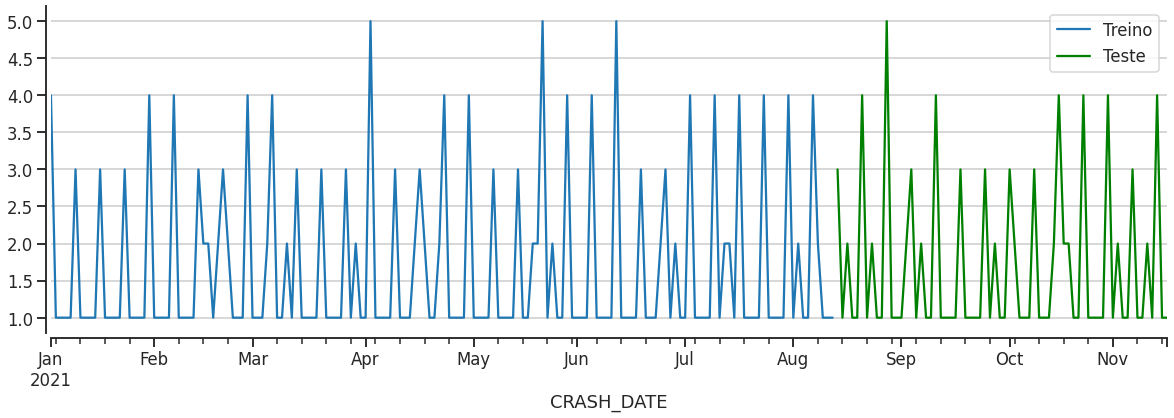

In [82]:
size_of_train = int(np.ceil(df_NYC_janela.shape[0] * 0.70))
train = df_NYC_janela.iloc[:size_of_train]
test = df_NYC_janela.iloc[size_of_train:]

fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [83]:
'''model = auto_arima(train,
                   start_p=1,
                   start_q=1,
                   max_p=8,
                   max_q=8,
                   m=12,
                   d=1,
                   D=1,
                   seasonal=True,
                   stepwise=False,
                   random_state=20,
                   n_fits=30)'''

model_arima = auto_arima(train,
                   start_p=1,
                   start_q=2,
                   max_p=4,
                   max_q=4,
                   m=12,
                   d=None,
                   D=None,
                   seasonal=True,
                   stepwise=False,
                   stationary=False,
                   random_state=20,
                   n_fits=30)

In [84]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(4, 0, 1)   Log Likelihood                -165.995
Date:                Mon, 11 Apr 2022   AIC                            345.991
Time:                        01:55:00   BIC                            367.517
Sample:                             0   HQIC                           354.732
                                - 160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.5481      0.362     18.078      0.000       5.838       7.258
ar.L1         -0.8720      0.085    -10.287      0.000      -1.038      -0.706
ar.L2         -0.6773      0.075     -8.981      0.000      -0.825      -0.529
ar.L3         -0.6714      0.079     -8.463      0.000      -0.827      -0.516
ar.L4         -0.7467      0.057    -13.060      0.000      -0.859      -0.635
ma.L1          0.6414      0.102      6.268      0.000       0.441       0.842
sigma2         0.4556      0.051      8.951      0.000       0.356       0.555
===================================================================================
Ljung-Box (L1) (Q):                   9.33   Jarque-Bera (JB):                45.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             1.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
model_arima.fit(train)

ARIMA(order=(4, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [86]:
y_predict = model_arima.predict(n_periods = len(test))

In [87]:
y_predict_df = pd.Series(y_predict, index=test.index)
y_predict_df

CRASH_DATE
2021-08-13    2.874733
2021-08-16    1.946019
2021-08-17    1.486087
2021-08-18    1.257527
2021-08-19    0.991932
                ...   
2021-11-10    1.647608
2021-11-11    1.644661
2021-11-12    1.666604
2021-11-15    1.631885
2021-11-16    1.661885
Freq: C, Length: 68, dtype: float64

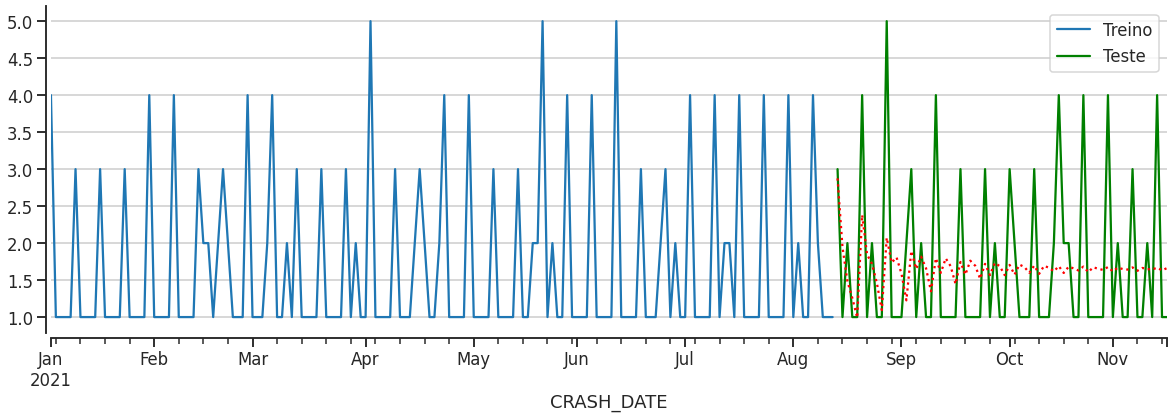

In [88]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")
sns.set_context("talk")

train.plot(ax=ax)
test.plot(ax=ax, c="g")
y_predict_df.plot(ax=ax, c="r", ls=":")

ax.yaxis.grid(True)
ax.legend(["Treino", "Teste"])
sns.despine(offset=5, trim=False)

In [89]:
print("R2 Score: ", r2_score(test, y_predict_df[test.index]))
print("MSE: ", mean_squared_error(test, y_predict_df))
print("RMSE: ", mean_squared_error(test, y_predict_df, squared=False))

R2 Score:  0.13346540082187075
MSE:  0.9750388234264288
RMSE:  0.9874405417170335


In [90]:
train_prophet = train.reset_index().rename(columns={'CRASH_DATE': 'ds', 'PERSON_AGE': 'y'})
train_prophet.head()

,ds,y
0,2021-01-01,4
1,2021-01-04,1
2,2021-01-05,1
3,2021-01-06,1
4,2021-01-07,1


In [91]:
model_prophet = Prophet(seasonality_mode="multiplicative")
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/usr/local/lib/python3.7/dist-packages/fbprophet/forecaster.py:401: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the p

In [92]:
periods = df_NYC_janela.shape[0] - size_of_train

In [94]:
future = model_prophet.make_future_dataframe(periods=periods, freq="C")
forecast = model_prophet.predict(future)

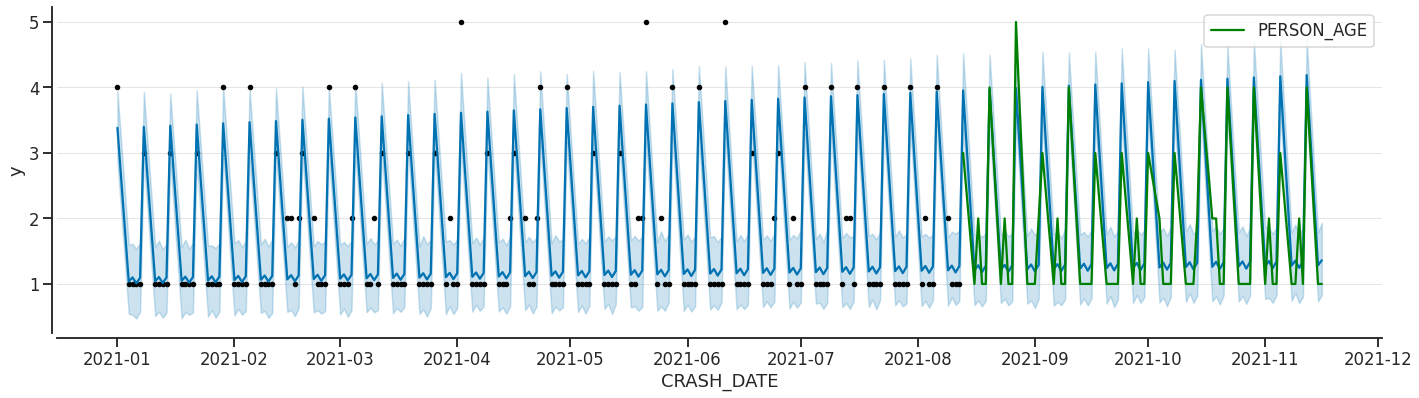

In [95]:
fig, ax= plt.subplots(1, 1, figsize=(20, 6))
sns.set_style("ticks")

sns.set_context("talk")
model_prophet.plot(forecast, ax=ax);

test.plot(ax=ax, c="g");
ax.yaxis.grid(True)

sns.despine(offset=5, trim=False)

In [96]:
yhat_test = forecast.yhat[size_of_train:]

print("R2 Score: ", r2_score(test, yhat_test))
print("MSE: ", mean_squared_error(test, yhat_test))
print("RMSE: ", mean_squared_error(test, yhat_test, squared=False))

R2 Score:  0.7686537052556974
MSE:  0.26031461322547716
RMSE:  0.5102103617386432


In [100]:
pickle.dump(model_prophet, open('model_prophet.sav', 'wb'))

In [99]:
pickle.dump(model_arima, open('model_arima.sav', 'wb'))